# Classification with Dynamic Time Warping

## Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import dtw
from statistics import mode
import utils
import os
import time

RESULTS_DIR = "results_twoPattern"
DATA_PICKLE_FILE = "data_two_pat/two_pattern_diff_lens.pkl"
CLS_NAME = "DTW"
SPLIT_ID = 0

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Load data

In [2]:
with open(DATA_PICKLE_FILE, "rb") as f:
    data = pickle.load(f)

data.keys()

dict_keys(['generating_model', 'data_filename', 'time_index', 'models_lst', 'labels_df', 'all_X_samples', 'indices_splits_lst', 'metadata', 'description'])

In [3]:
print(data["metadata"])

{'N_TRAIN_SAMPLES_PER_MODEL': 1000, 'N_TEST_SAMPLES_PER_MODEL': 4000, 'MAX_SAMPLE_LEN': 127, 'MIN_SAMPLE_LEN': 89}


In [4]:
indices_splits_lst = data["indices_splits_lst"]
all_X_samples = data["all_X_samples"]
labels_df = data["labels_df"]
current_split = indices_splits_lst[SPLIT_ID]
train_samples_ids = current_split["train_samples_ids"]
test_samples_ids = current_split["test_samples_ids"]

In [5]:
len(current_split["test_samples_ids"])

4000

## Classify test samples with DTW
For each test sample find DTW distance to all samples in train subset and classify as the closest one's label.

In [6]:
# TODO try cross-validation to choose better k
def classify_sample(X: np.ndarray, train_samples: list[np.ndarray], train_labels: list[int], k_lst: list[int]) -> dict[int, int]:
    """Classify a sample using DTW with k-NN based on samples in `train_samples` with different values of k.
    Returns a mapping k -> returned label."""
    results = dict()
    for k in k_lst:
        if k >= len(train_samples):
            raise ValueError("k >= number of train examples doesn't make sense in KNN-classifier.")
        distances = []
        for Y in train_samples:
            normalized_dist = dtw.dtw(X, Y, distance_only= True).normalizedDistance
            distances.append(normalized_dist)
        first_k = np.argsort(distances)[:k]
        results[k] = mode(train_labels[first_k])
    return results 


In [7]:
train_df = labels_df.loc[train_samples_ids]
train_ids = train_df.index.values.astype('int')
train_samples = [all_X_samples[id] for id in train_ids]
train_labels = train_df["true_label"].values

test_df = labels_df.loc[test_samples_ids]
test_ids = test_df.index.values.astype('int')
test_samples = [all_X_samples[id] for id in test_ids]

In [8]:
start = time.time()
predictions_1NN = [classify_sample(X, train_samples, train_labels, 1) for X in test_samples]
predictions_5NN = [classify_sample(X, train_samples, train_labels, 5) for X in test_samples]

df_1NN = pd.DataFrame({"pred": predictions_1NN}, index= test_df.index)
df_5NN = pd.DataFrame({"pred": predictions_5NN}, index= test_df.index)

stop = time.time()
total_time = stop - start
print(f"Time needed to classify all test samples: {total_time:.2f}s")

predictions_dfs = {
    "1NN": test_df.join(df_1NN),
    "5NN": test_df.join(df_5NN)
}

predictions_dfs["1NN"].head()

Time needed to classify all test samples: 2283.77s


,sample_id,true_label,sample_len,pred
0,0,1,119,1
1,1,2,92,2
2,2,0,99,0
3,3,2,109,0
4,4,1,108,1


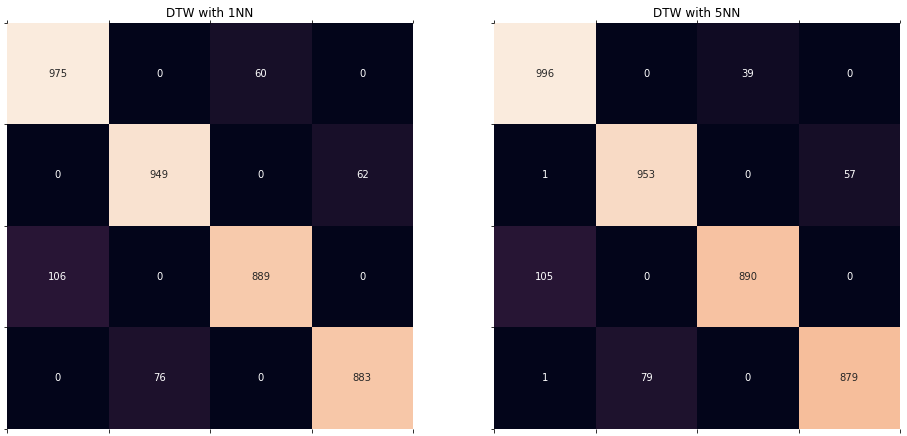

In [9]:
y_true = test_df["true_label"]
y_pred_1NN = predictions_dfs["1NN"]["pred"]
y_pred_5NN = predictions_dfs["5NN"]["pred"]

cm_1NN = confusion_matrix(y_true, y_pred_1NN)
cm_5NN = confusion_matrix(y_true, y_pred_5NN)

plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['font.size'] = 10
fig, axes = plt.subplots(ncols = 2)
sns.heatmap(cm_1NN, annot=True, fmt='g', ax=axes[0], cbar = False)
axes[0].matshow(cm_1NN)
axes[0].set_title("DTW with 1NN")
sns.heatmap(cm_5NN, annot=True, fmt='g', ax=axes[1], cbar = False)
axes[1].matshow(cm_5NN)
axes[1].set_title("DTW with 5NN")
plt.show()

In [10]:
accuracies = dict()
for variant, df in predictions_dfs.items():
    acc = utils.accuracy(y_true, df["pred"])
    accuracies[variant] = acc
    print(f"{variant} accuracy: {acc:.4f}")

1NN accuracy: 0.9240
5NN accuracy: 0.9295


In [11]:
time_index = data["time_index"]
summary = {
    "data_filename": DATA_PICKLE_FILE,
    "classificator": CLS_NAME,
    "time_index": time_index,
    "split_id": SPLIT_ID,
    "predictions_dfs": predictions_dfs,
    "accuracies": accuracies,
    "total_time": total_time
}

for key, val in summary.items():
    print(f"{key}: {val}")

data_filename: data_two_pat/two_pattern_diff_lens.pkl
classificator: DTW
time_index: 1661512203
split_id: 0
predictions_dfs: {'1NN':       sample_id  true_label  sample_len  pred
0             0           1         119     1
1             1           2          92     2
2             2           0          99     0
3             3           2         109     0
4             4           1         108     1
...         ...         ...         ...   ...
3995       3995           1         124     1
3996       3996           1         124     1
3997       3997           1         118     1
3998       3998           1         121     1
3999       3999           0         125     0

[4000 rows x 4 columns], '5NN':       sample_id  true_label  sample_len  pred
0             0           1         119     1
1             1           2          92     2
2             2           0          99     0
3             3           2         109     0
4             4           1         108     1
...   

In [12]:
gen_type = data["generating_model"]
split_id_str = str(SPLIT_ID)
if len(split_id_str) == 1:
    split_id_str = "0" + split_id_str

output_path = f"{RESULTS_DIR}/dtw_results_for_{gen_type}_{time_index}_{split_id_str}.pkl"
if os.path.exists(output_path):
    inp = input(f"Classification results {output_path} already exists. Do you want to overwrite it? (y = yes)")
    if inp in ["y", "Y"]:
        with open(output_path, 'wb') as f:
                pickle.dump(summary, f)
                print(f"Updated classification results saved to {output_path}.")
    else:
        print("Canceled.")
else:
    with open(output_path, 'wb') as f:
        pickle.dump(summary, f)
        print(f"Classification results saved to {output_path}.")

Classification results saved to results_twoPattern/dtw_results_for_SIM_TwoPat_1661512203_00.pkl.
